In [4]:
import pandapower as pp
import pandas as pd
import pandapower.networks as nw
import matplotlib.pyplot as plt
import os
import pandapower.plotting as plot

#Import an example network:
net = nw.mv_oberrhein()

# You can accesss all parameters of one element  or one parameter of multiple elements with the .loc command.
# The values are returned as a pandas series. 
# To get them in an array instead, use the values function. 
# Multiple parameters of multiple elements are returned as a pandas dataframe.

# To access exactly one parameter, .at can be used instead of .loc 
# This .at solution can only be used for exactly one parameter, but is siginifcantly faster than using .loc. 
# That is why we should always use .at if possible!


# b = net.bus.vn_kv
# for i,j in enumerate(b):
#     if(j > 30.0):
#         print(i, j)

net.bus[net.bus.vn_kv > 30.0]

# Please be aware that the boolean query always returns a copy of the dataframe.
# We can change that copy, but not the original table. 
# That is why we need to save the index of the copied bus table and than change the value of the original table. 

# Merging different dataframes of the network
bus_voltages = pd.concat([net.line.name, net.bus.vn_kv], axis=1) #axis={horizontal=0, vertical=1}: axis to concatenate along

#Output
bus_voltages.head(n=8)



,name,vn_kv
0,Line 0,20.0
1,Line 1,20.0
2,Line 2,20.0
3,Line 3,20.0
4,Line 4,20.0
5,Line 5,20.0
6,Line 6,20.0
7,Line 7,20.0


<AxesSubplot:>

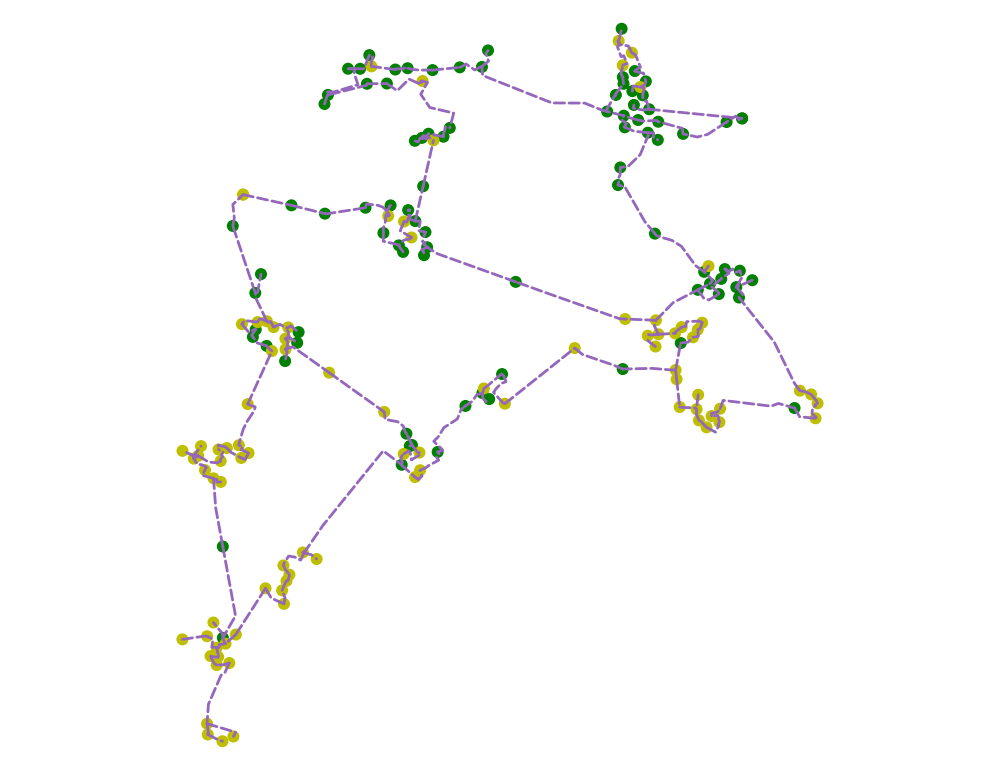

In [29]:
# Dividing the line in different zones
nr_buses = int(len(net.bus.index) / 2)
net.bus.loc[net.bus.index[:nr_buses], "zone"] = "A"
net.bus.loc[net.bus.index[nr_buses:], "zone"] = "B"
net.bus.zone.head()

#plot.simple_plot(net, show_plot=True)

try:
    import seaborn
    colors = seaborn.color_palette()
except:
    colors = ["b", "g", "r", "c", "y"]
%matplotlib inline

# Split the network in two zones (first half of buses in zone A and second half in zone B)
# Plot with different colours for each zone.

bc1 = plot.create_bus_collection(net, net.bus[net.bus.zone == 'A'].index, size=120, color='g', zorder=1) #create buses zone A
bc2 = plot.create_bus_collection(net, net.bus[net.bus.zone == 'B'].index, size=120, color='y', zorder=1) #create buses zone B
lcd = plot.create_line_collection(net, net.line.index, linestyles = 'dashed', linewidth = 2, color = colors[4])
plot.draw_collections([bc1, bc2, lcd]) # plot two zones in different colors


<AxesSubplot:>

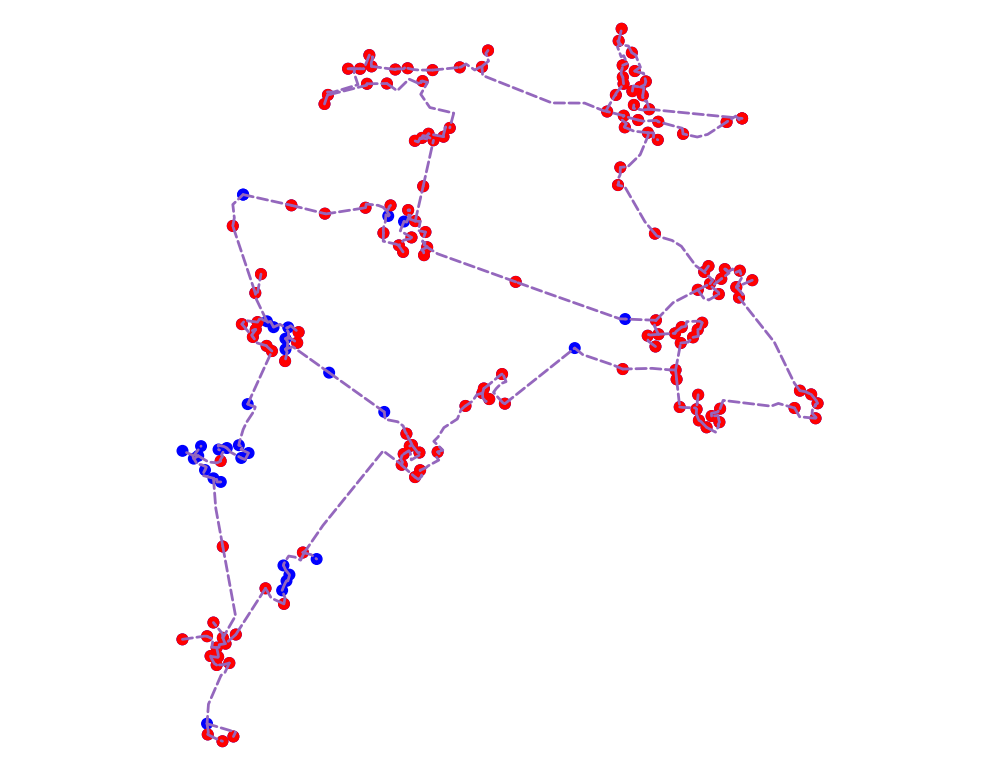

In [54]:
# Plot all nodes which have a load connected in red, and all other nodes in blue

load = net.load.index.tolist() # creating the list of all nodes with load
bc1 = plot.create_bus_collection(net, net.bus.index[load], size = 120, color = 'r', zorder = 2) 
bc2 = plot.create_bus_collection(net, net.bus.index, size = 120, color = 'b', zorder = 1)
lcd = plot.create_line_collection(net, net.line.index, linestyles = 'dashed', linewidth = 2, color = colors[4])

# Notice that the zorder is higher for the load nodes collection.
# This ensures that the red nodes collection is plotted over the blue nodes collection.

plot.draw_collections([bc1,bc2,lcd])


<AxesSubplot:>

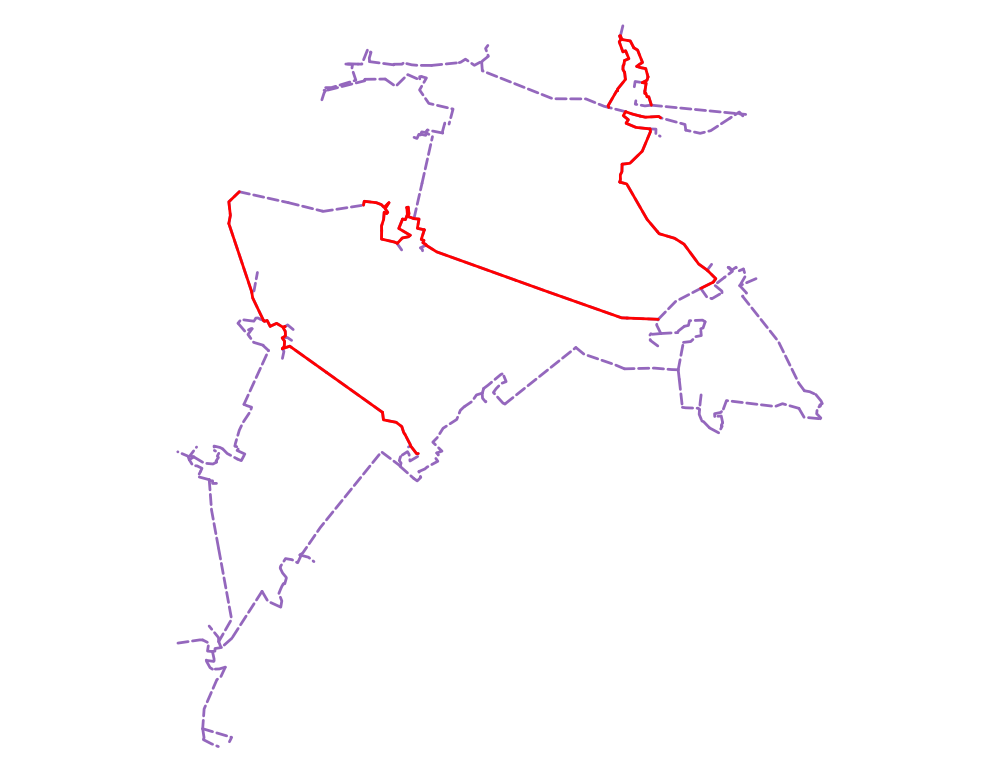

In [64]:
# Run a power flow and plot all lines with loading more than 40% in red (Method 1 using net.res_line funtion)

pp.runpp(net)
loads = net.res_line.loading_percent
ind = []
for i,load in enumerate(loads):
    if(load > 40):
        ind.append(int(i))
lcd = plot.create_line_collection(net, net.line.index, linestyles = 'dashed', linewidth = 2, color = colors[4])
lc1 = plot.create_line_collection(net, net.line.index[ind], linewidth = 2, color = 'r')
plot.draw_collections([lcd,lc1])

<AxesSubplot:>

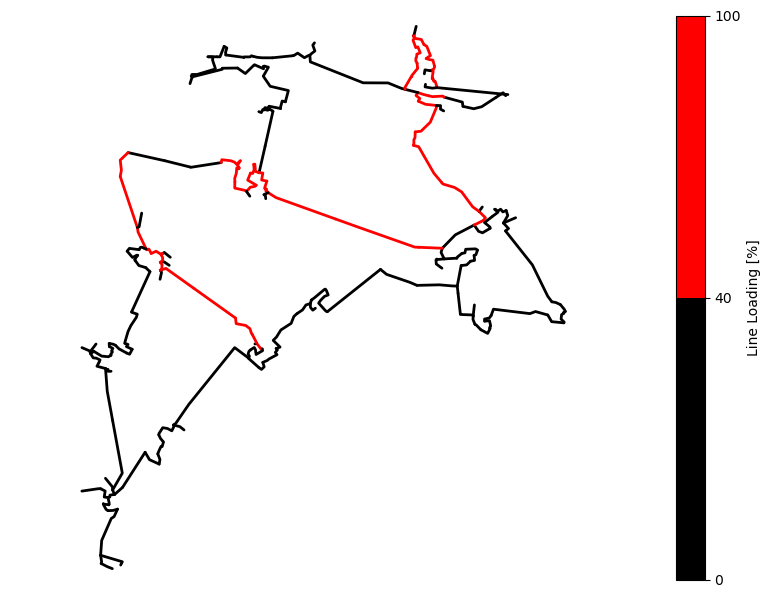

In [68]:
# Run a power flow and plot all lines with loading more than 40% in red (Method 2 using colormaps)

pp.runpp(net)
cmap_list=[((0,40),"black"), ((40,100) ,"red")]
cmap, norm = plot.cmap_discrete(cmap_list)
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=2)
plot.draw_collections([lc], figsize=(8,6))

The number of given colors (1) is smaller than the number of nodes (179) to draw! The colors will be repeated to fit.
The number of given colors (1) is smaller than the number of nodes (14) to draw! The colors will be repeated to fit.


<AxesSubplot:>

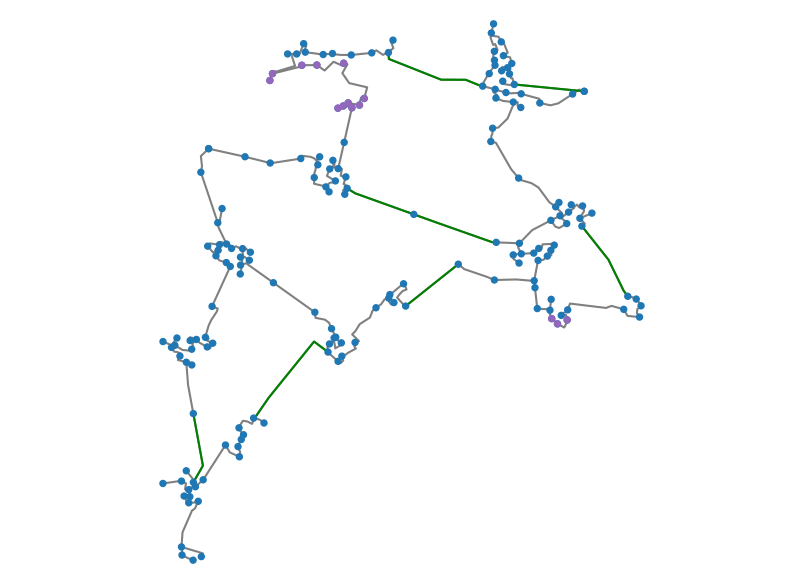

In [15]:
import matplotlib.pyplot as plt
import os
import pandapower as pp
import pandapower.plotting as plot
import pandapower.networks as nw
try:
    import seaborn
    colors = seaborn.color_palette()
except:
    colors = ["b", "g", "r", "c", "y"]
%matplotlib inline

net = nw.mv_oberrhein()
long_lines = net.line[net.line.length_km > 2.].index
lc = plot.create_line_collection(net, net.line.index, color="grey", zorder=1)
lcl = plot.create_line_collection(net, long_lines, color="g", zorder=2)

pp.runpp(net)

low_voltage_buses = net.res_bus[net.res_bus.vm_pu < 0.98].index
bc = plot.create_bus_collection(net, net.bus.index, size=90, color=colors[0], zorder=10)
bch = plot.create_bus_collection(net, low_voltage_buses, size=90, color=colors[4], zorder=11)
plot.draw_collections([lc, lcl, bc, bch], figsize=(8,6))


The number of given colors (1) is smaller than the number of nodes (179) to draw! The colors will be repeated to fit.
The number of given colors (1) is smaller than the number of nodes (45) to draw! The colors will be repeated to fit.
The number of given colors (1) is smaller than the number of nodes (2) to draw! The colors will be repeated to fit.


<AxesSubplot:>

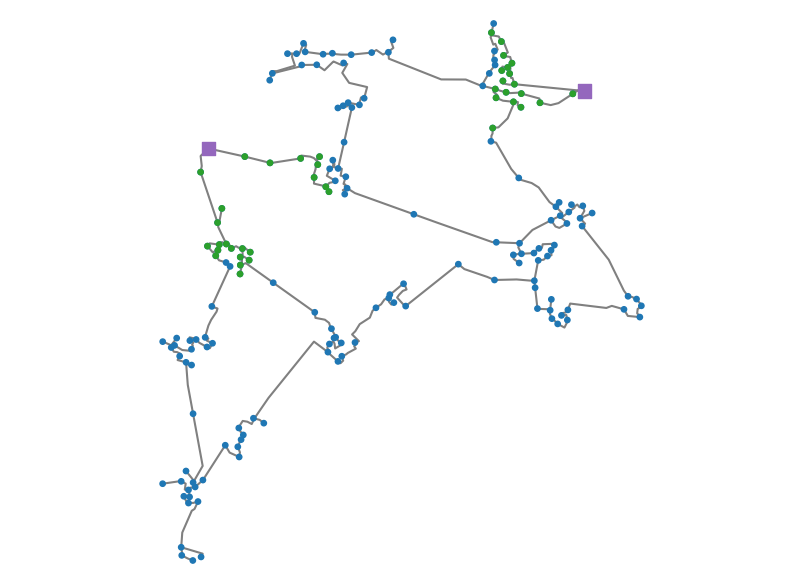

In [16]:
net = nw.mv_oberrhein()
close_buses = set()
for slack in net.ext_grid.bus:
    d = pp.topology.calc_distance_to_bus(net, slack)
    close_buses |= set(d[d < 5].index)

bc = plot.create_bus_collection(net, net.bus.index, size=80, color=colors[0], zorder=1)
bch = plot.create_bus_collection(net, close_buses, size=80, color=colors[2], zorder=2)
lc = plot.create_line_collection(net, net.line.index, zorder=1, color="grey")
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=200, color=colors[4], zorder=11)
plot.draw_collections([lc, bc, bch, sc], figsize=(8,6))

The number of given colors (1) is smaller than the number of nodes (179) to draw! The colors will be repeated to fit.
The number of given colors (1) is smaller than the number of nodes (2) to draw! The colors will be repeated to fit.


<AxesSubplot:>

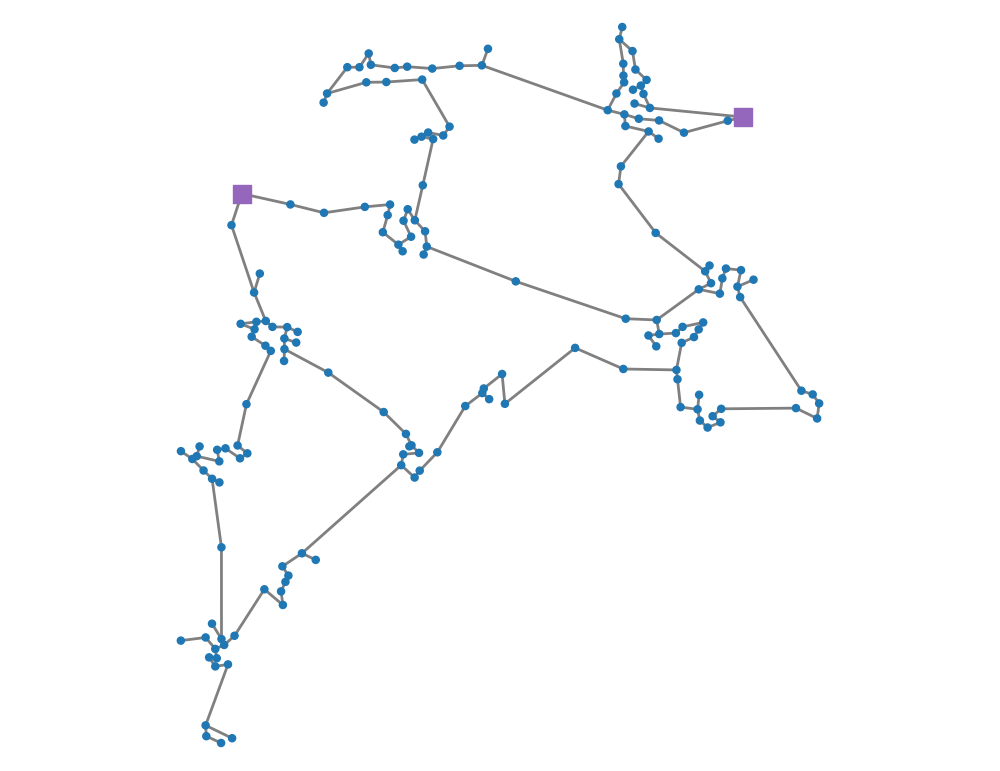

In [17]:
net = nw.mv_oberrhein()
bc = plot.create_bus_collection(net, net.bus.index, size=80, color=colors[0], zorder=10)
lcd = plot.create_line_collection(net, net.line.index, use_bus_geodata=True, color="grey", linewidths=2.)
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=200,
                                              color=colors[4], zorder=11)
plot.draw_collections([lcd, bc, sc])

The number of given colors (1) is smaller than the number of nodes (179) to draw! The colors will be repeated to fit.
The number of given colors (1) is smaller than the number of nodes (2) to draw! The colors will be repeated to fit.


<AxesSubplot:>

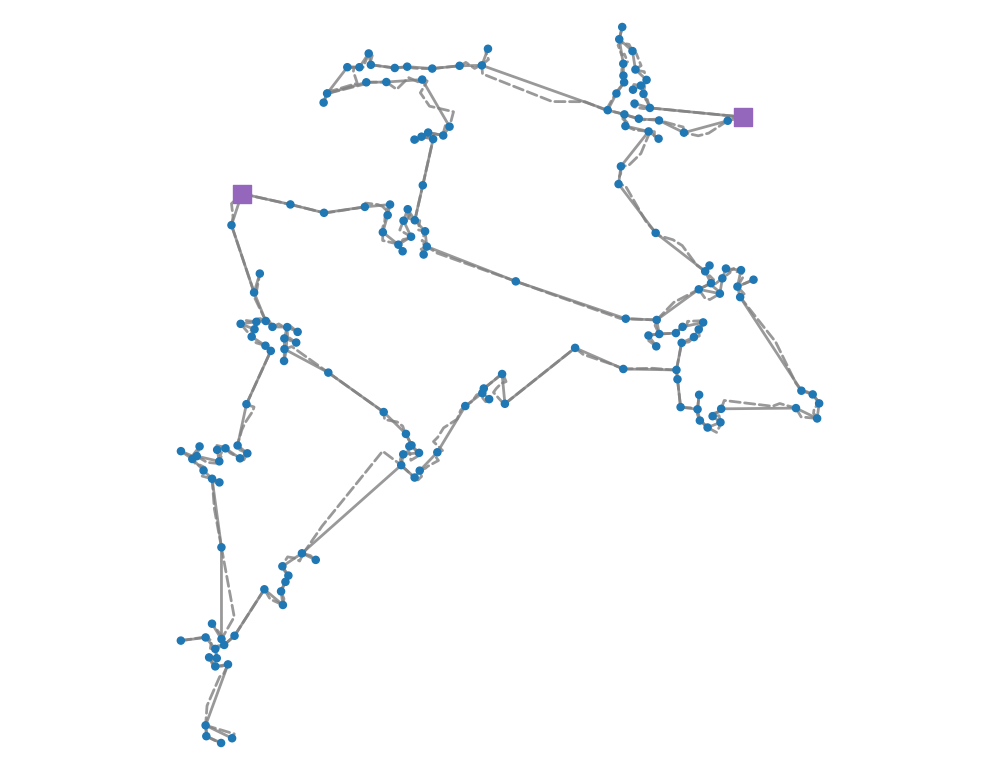

In [18]:
net = nw.mv_oberrhein()
bc = plot.create_bus_collection(net, net.bus.index, size=80, color=colors[0], zorder=10)
lcd = plot.create_line_collection(net, lines=net.line.index, color="grey",alpha=0.8, linewidths=2., use_bus_geodata=True)
lc = plot.create_line_collection(net, lines=net.line.index, color="grey",alpha=0.8, linestyles="dashed", linewidths=2.)
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=200,
                                              color=colors[4], zorder=11)
plot.draw_collections([lc, lcd, bc, sc])